In [1]:
import numpy as np 
import time 
import os  
import xarray as xr
import psutil
import gc

year_list = np.arange(1996,2005)
year_list = np.arange(1996,1997)
# for ti in range(1,7):
ori_var = [
 'olr',
 'lwdn_sfc',
 'swdn_sfc',
 'swup_sfc',
 'swup_toa',
 'tdt_lw',
 'tdt_sw',
 'tdt_lw_clr',
 'tdt_sw_clr',
 'olr_clr',
 'lwdn_sfc_clr',
 'swdn_sfc_clr',
 'swup_sfc_clr',
 'swup_toa_clr',]
def build_var_list(ds, orivar):
    err_var = []
    for _ in orivar:
        if _ in list(ds.variables) : 
            # check nn var
            if f'nn_{_}' in list(ds.variables) : 
                err_var.append(_) 
            else:
                print(f'nn_{_} do not exist in data file. Please check!')
        else:
            print(f'{_} do not exist in data file. Please check!')
    return err_var
xe = np.arange(-4,4.01,0.2)
err_pred_hist = np.zeros(len(xe)-1)
err_pred_hist_err = np.zeros(len(xe)-1)
for year in year_list:
    for ti in range(1,2):
        # file_path = '/scratch/gpfs/cw55/AM4/work/CTL2000_test2000s_nn_stellarcpu_intelmpi_22_768PE/'
        # ds= xr.open_mfdataset([file_path+f'HISTORY/{year}0101.atmos_8xdaily.tile{ti}.nc' for year in year_list])  
        # ds_nn_3h = ds

        file_path = '/scratch/gpfs/cw55/AM4/work/CTL2000_test2000s_nn_stellarcpu_intelmpi_22_768PE_base/' 
        filename= file_path+f'HISTORY/{year}0101.atmos_8xdaily.tile{ti}.nc'

        zero_time = time.time()
        # file_stats = os.stat(filename)
        # print(f"Converting file: {filename} | Raw file size: {file_stats.st_size / (1024**3):5.1f} GB ")
        os.system(f'cp --parents {filename} /dev/shm/')
        print("loaded data into /dev/shm")
        with xr.open_dataset(f"/dev/shm/{filename}").isel(time=slice(None,-1)) as ds: 
            var_list=build_var_list(ds,ori_var)
            eng_err_check = ds['nn_lwup_sfc'].load()
            
            err_pred = {}
            for svar in ori_var:
                # warp operations in with statement to manage the memory better
                sta_time = time.time()
                print(f'Read {svar:12s} ...', end='')
                da = ds[svar].load()
                nnda = ds[f'nn_{svar}'].load() 
                # # Getting % usage of virtual_memory ( 3rd field)
                # print('RAM memory % used:', psutil.virtual_memory()[2],end = '| ')
                # # Getting usage of virtual_memory in GB ( 4th field)
                # print('RAM Used (GB):', psutil.virtual_memory()[3]/1e9)

                err_pred[svar] = abs(nnda - da)/(abs(da).mean(['time'])+1e-12)
                print(f' done. Use time: {time.time() - sta_time: 3.0f}s')
                del da, nnda
                # gc.collect()
        used_time = time.time() - zero_time  
        print(f'    | timer: {used_time:4.0f}s')
        os.system(f'rm -f  /dev/shm/{filename}')
        # calculate index
        err_pred_index = err_pred[ori_var[0]].copy()
        for svar in ori_var[1:]:
            if 'tdt' in svar:
                err_pred_index += err_pred[svar].sum('pfull')
                # pass
            else:
                err_pred_index += err_pred[svar]
                
        err_pred_index_log1 = np.log(err_pred_index.values.flatten()/142)/np.log(10)
        index_sel = np.argwhere(eng_err_check.values.flatten()<0)
        err_pred_index_log2 = err_pred_index_log1[index_sel]
        hist1,xe = np.histogram(err_pred_index_log1,xe)
        hist2,xe = np.histogram(err_pred_index_log2,xe)
        err_pred_hist     += hist1
        err_pred_hist_err += hist2

import pickle
with  open('important', 'wb') as file:
    pickle.dump([xe,err_pred_hist,err_pred_hist_err],file)

loaded data into /dev/shm
Read olr          ... done. Use time:   0s
Read lwdn_sfc     ... done. Use time:   0s
Read swdn_sfc     ... done. Use time:   0s
Read swup_sfc     ... done. Use time:   0s
Read swup_toa     ... done. Use time:   0s
Read tdt_lw       ... done. Use time:  10s
Read tdt_sw       ... done. Use time:  10s
Read tdt_lw_clr   ... done. Use time:  10s
Read tdt_sw_clr   ... done. Use time:  10s
Read olr_clr      ... done. Use time:   0s
Read lwdn_sfc_clr ... done. Use time:   0s
Read swdn_sfc_clr ... done. Use time:   0s
Read swup_sfc_clr ... done. Use time:   0s
Read swup_toa_clr ... done. Use time:   0s
    | timer:   61s


/tmp/ipykernel_2375376/2740828018.py:24: RuntimeWarning: invalid value encountered in true_divide
  alarm_rate = err_pred_hist_err/err_pred_hist


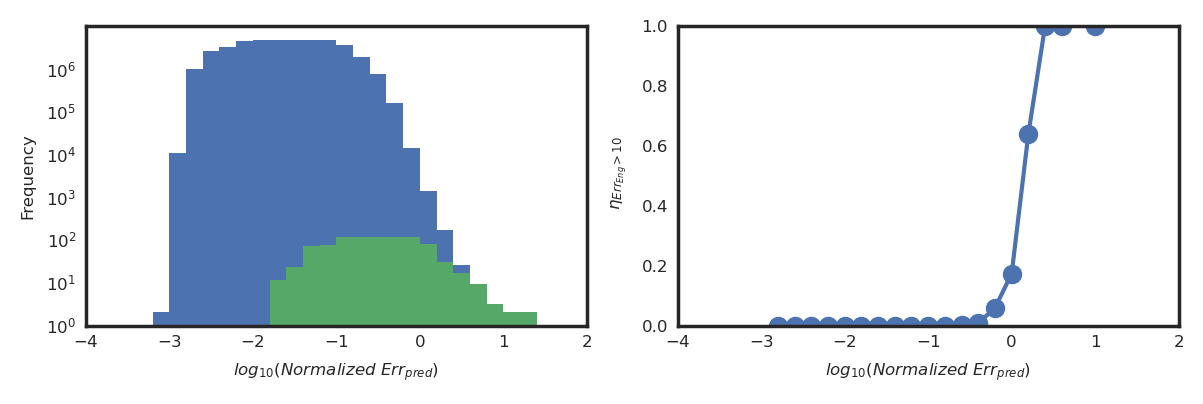

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import pickle
with  open('important', 'rb') as file:
    [xe,err_pred_hist,err_pred_hist_err] = pickle.load(file)

plt.rcParams['font.size'] = '6'

plt.style.reload_library()
plt.style.use('seaborn-deep')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,2),dpi=200, tight_layout=True) 
axs= axs.flatten()
ax = axs[0]
ax.bar(xe[:-1],err_pred_hist)
ax.bar(xe[:-1],err_pred_hist_err)
ax.set_xlabel(r'$log_{10}(Normalized\ Err_{pred})$')
ax.set_yscale('log')
ax.set_ylabel('Frequency')
ax.set_xlim(-4,2)

ax = axs[1]
alarm_rate = err_pred_hist_err/err_pred_hist
ax.plot(xe[:-1],alarm_rate,'-o', label='Eerr>10')
ax.set_xlabel(r'$log_{10}(Normalized\ Err_{pred})$')
ax.set_ylabel(r' $\eta_{Err_{Eng} > 10}$')
ax.set_ylim([0,1])
ax.set_xlim(-4,2)
fig.show()

/tmp/ipykernel_3440848/1531856997.py:35: RuntimeWarning: invalid value encountered in true_divide
  alarm_rate = err_pred_hist_err/err_pred_hist


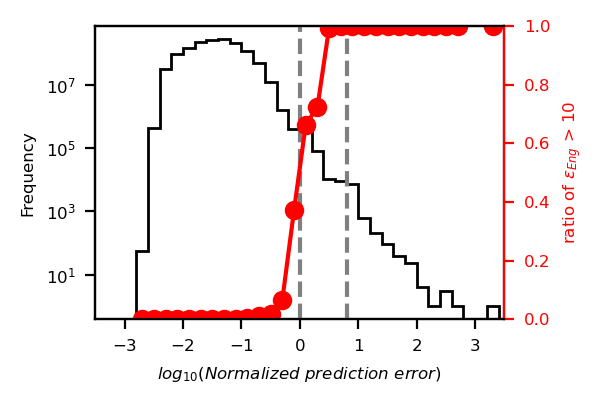

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import pickle
with  open('error_eng_stats_hist_1996_2004_interactive.p', 'rb') as file:
    [xe,err_pred_hist,err_pred_hist_err] = pickle.load(file)

plt.rcParams['font.size'] = '6'

plt.style.reload_library()
plt.style.use('seaborn-deep')
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3,2),dpi=200, tight_layout=True) 
# axs= axs.flatten()
ax = axs
ax.stairs(err_pred_hist,xe,color='black')
# ax.stairs(err_pred_hist_err,xe,fc='None',ec='grey')
ax.set_xlabel(r'$log_{10}(Normalized\ prediction\ error)$')
ax.set_yscale('log')
ax.set_ylabel('Frequency')
ax.set_xlim(-3.5,3.5)
#99% line
cum_pct = np.cumsum(err_pred_hist)/np.sum(err_pred_hist)
index_99pct = np.argmin(np.abs(cum_pct-0.99))
index_99p99pct = np.argmin(np.abs(cum_pct-0.9999))
index_99p9999pct = np.argmin(np.abs(cum_pct-0.999999))
# plt.plot([xe[index_99pct],xe[index_99pct]],[0,err_pred_hist[index_99pct]],'--',c='grey')
# plt.plot([xe[index_99p99pct],xe[index_99p99pct]],[0,err_pred_hist[index_99p99pct]],'--',c='grey')
# plt.plot([xe[index_99p9999pct],xe[index_99p9999pct]],[0,err_pred_hist[index_99p9999pct]],'--',c='grey')

ax = ax.twinx()
plt.plot([xe[index_99p99pct],xe[index_99p99pct]],[0,1],'--',c='grey')
plt.plot([xe[index_99p9999pct],xe[index_99p9999pct]],[0,1],'--',c='grey')

alarm_rate = err_pred_hist_err/err_pred_hist
ax.plot((xe[:-1]+xe[1:])/2, alarm_rate, '-o', color='red', label='Eerr>10')
# ax.plot(xe[:-1],alarm_rate,'-o', c='red', label='Eerr>10')
# ax.stairs(np.cumsum(err_pred_hist)/np.sum(err_pred_hist),xe,color='black')
# ax.set_xlabel(r'$log_{10}(Normalized\ Err_{pred})$')
ax.set_ylabel('ratio of $\epsilon_{Eng}$ > 10')
ax.set_ylim([0,1])
ax.spines['right'].set_color('red')
ax.yaxis.label.set_color('red')
ax.tick_params(axis='y', colors='red')
fig.show()

In [126]:
np.sum(err_pred_hist)/1e9

1.45400832

In [122]:
xe[index_99pct]

-0.7999999999999972

In [123]:
10**xe[index_99pct]

0.1584893192461124

In [124]:
xe[index_99p99pct]

3.552713678800501e-15

In [113]:
cdf

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.26407464e-08, 2.91544412e-04,
       2.20813420e-02, 9.14923912e-02, 1.93216934e-01, 3.50248816e-01,
       5.35225936e-01, 7.27796597e-01, 8.73171052e-01, 9.55602999e-01,
       9.90281480e-01, 9.98555271e-01, 9.99597276e-01, 9.99819323e-01,
       9.99957104e-01, 9.99992032e-01, 9.99995580e-01, 9.99997973e-01,
       9.99999460e-01, 9.99999743e-01, 9.99999874e-01, 9.99999936e-01,
       9.99999968e-01, 9.99999981e-01, 9.99999993e-01, 9.99999997e-01,
       9.99999999e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

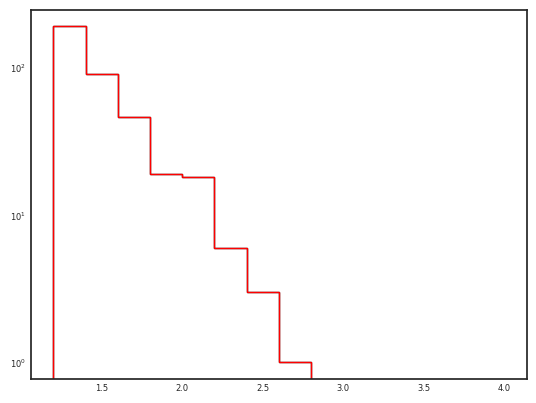

In [149]:
xe_lim_ind = 26
plt.stairs(err_pred_hist    [xe_lim_ind:],xe[xe_lim_ind:],color='black')
plt.stairs(err_pred_hist_err[xe_lim_ind:],xe[xe_lim_ind:],color='red')
plt.yscale('log')

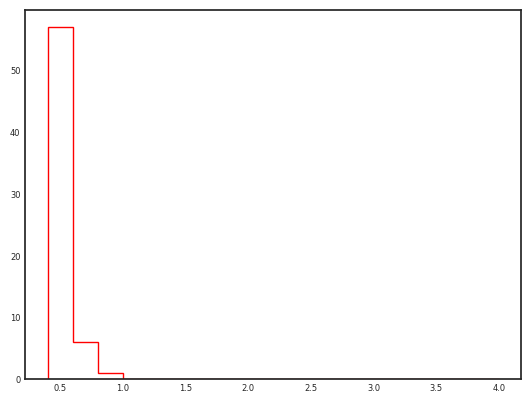

In [156]:
xe_lim_ind = 22
plt.stairs(err_pred_hist    [xe_lim_ind:]-err_pred_hist_err[xe_lim_ind:],xe[xe_lim_ind:],color='red')
# plt.yscale('log')

/tmp/ipykernel_3440848/2057681976.py:35: RuntimeWarning: invalid value encountered in true_divide
  alarm_rate = err_pred_hist_err/err_pred_hist


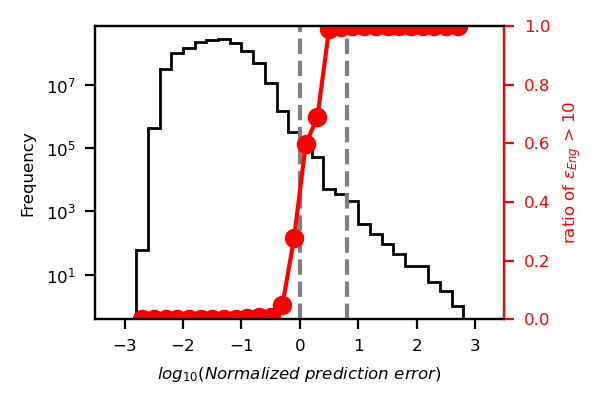

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import pickle
with  open('error_eng_stats_hist_1996_2004.diagnostic.p', 'rb') as file:
    [xe,err_pred_hist,err_pred_hist_err] = pickle.load(file)

plt.rcParams['font.size'] = '6'

plt.style.reload_library()
plt.style.use('seaborn-deep')
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3,2),dpi=200, tight_layout=True) 
# axs= axs.flatten()
ax = axs
ax.stairs(err_pred_hist,xe,color='black')
# ax.stairs(err_pred_hist_err,xe,fc='None',ec='grey')
ax.set_xlabel(r'$log_{10}(Normalized\ prediction\ error)$')
ax.set_yscale('log')
ax.set_ylabel('Frequency')
ax.set_xlim(-3.5,3.5)
#99% line
cum_pct = np.cumsum(err_pred_hist)/np.sum(err_pred_hist)
index_99pct = np.argmin(np.abs(cum_pct-0.99))
index_99p99pct = np.argmin(np.abs(cum_pct-0.9999))
index_99p9999pct = np.argmin(np.abs(cum_pct-0.999999))
# plt.plot([xe[index_99pct],xe[index_99pct]],[0,err_pred_hist[index_99pct]],'--',c='grey')
# plt.plot([xe[index_99p99pct],xe[index_99p99pct]],[0,err_pred_hist[index_99p99pct]],'--',c='grey')
# plt.plot([xe[index_99p9999pct],xe[index_99p9999pct]],[0,err_pred_hist[index_99p9999pct]],'--',c='grey')

ax = ax.twinx()
plt.plot([xe[index_99p99pct],xe[index_99p99pct]],[0,1],'--',c='grey')
plt.plot([xe[index_99p9999pct],xe[index_99p9999pct]],[0,1],'--',c='grey')

alarm_rate = err_pred_hist_err/err_pred_hist
ax.plot((xe[:-1]+xe[1:])/2, alarm_rate, '-o', color='red', label='Eerr>10')
# ax.plot(xe[:-1],alarm_rate,'-o', c='red', label='Eerr>10')
# ax.stairs(np.cumsum(err_pred_hist)/np.sum(err_pred_hist),xe,color='black')
# ax.set_xlabel(r'$log_{10}(Normalized\ Err_{pred})$')
ax.set_ylabel('ratio of $\epsilon_{Eng}$ > 10')
ax.set_ylim([0,1])
ax.spines['right'].set_color('red')
ax.yaxis.label.set_color('red')
ax.tick_params(axis='y', colors='red')
fig.show()